# Circuit Simulation

### Import Libraries

In [1]:
import math
import numpy as np

In [36]:
from ahkab import new_dc, run
from ahkab.circuit import Circuit
from ahkab.plotting import plot_results # calls matplotlib for you
from ahkab.dc_analysis import dc_guess
from ahkab.results import dc_solution

import matplotlib.pyplot as plt

## Part 1: Pattern Calculation

In [3]:
def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [4]:
class Ink_circle:
    def __init__(self, center, radius):
        self.center = center
        self.radius = radius
        self.perim = 2 * math.pi * self.radius #周长

    def formula(self, point):
        # The formula of the circle
        return (point[0] - self.center[0])**2 + (point[1] - self.center[1])**2 - self.radius**2
    
    def insec_circle(self, circle):
        # Calculate the points of intersection between 'circle' and itself
        d = distance(self.center, circle.center)
        if d > self.radius + circle.radius or d < abs(self.radius - circle.radius):
            return "No Intersection"
        elif d == 0 and self.radius == circle.radius:
            return "Same Circle"
        else:
            A = (self.radius**2 - circle.radius**2 + d**2) / (2 * d)
            h = math.sqrt(self.radius**2 - A**2)
            x2 = self.center[0] + A * (circle.center[0] - self.center[0]) / d
            y2 = self.center[1] + A * (circle.center[1] - self.center[1]) / d
            x3 = x2 - h * (circle.center[1] - self.center[1]) / d
            y3 = y2 + h * (circle.center[0] - self.center[0]) / d
            x4 = x2 + h * (circle.center[1] - self.center[1]) / d
            y4 = y2 - h * (circle.center[0] - self.center[0]) / d
            
            p1 = (x3, y3)
            p2 = (x4, y4)
            return p1, p2

    def insec_line(self):
        # Calculate points of intersection between y = 0 and itself
        if self.radius <= abs(self.center[1]):
            return "No Intersection"
        else:
            h = abs(self.center[1])
            x1 = self.center[0] - math.sqrt((self.radius**2 - h**2))
            x2 = self.center[0] + math.sqrt((self.radius**2 - h**2))
            return (x1, 0), (x2, 0)
    
    def len_of_arc(self, p1, p2):
        # Calculate the length of arc between two points p1, p2 on the circle
        # It will return the length of the shorter arc.
        # To get the longer arc, use 'self.perim - self.len_of_arc(p1, p2)'
        if abs(self.formula(p1)) > 0.1 or abs(self.formula(p2)) > 0.1:
            return "Points are not on the circle"
        else:
            d = distance(p1, p2)
            angle = math.asin(d / (2 * self.radius))
            return 2 * angle * self.radius
        
    def draw(self):
        # To draw the circle
        angles_circle = [i * math.pi/180 for i in range(0,360)]
        x = [math.cos(i) * self.radius + self.center[0] for i in angles_circle]
        y = [math.sin(i) * self.radius + self.center[1] for i in angles_circle]
        return x, y

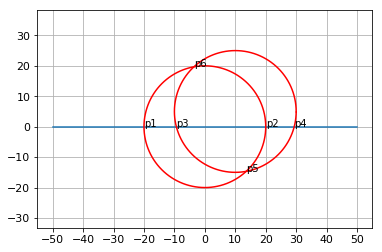

In [13]:
plt.figure()
plt.grid()
plt.xticks(np.arange(-50, 60, 10))
plt.yticks(np.arange(-50, 60, 10))

plt.plot((-50, 50), (0, 0))
cir1 = Ink_circle((0, 0), 20)
x1, y1 = cir1.draw()
plt.plot(x1, y1, 'r')

cir2 = Ink_circle((10, 5), 20)
x2, y2 = cir2.draw()
plt.plot(x2, y2, 'r')

txt = ["p1", "p2", "p3", "p4", "p5", "p6"]
insec_points = []
p1, p2 = cir1.insec_line()
p3, p4 = cir2.insec_line()
p5, p6 = cir2.insec_circle(cir1)

insec_points.append(p1)
insec_points.append(p2)
insec_points.append(p3)
insec_points.append(p4)
insec_points.append(p5)
insec_points.append(p6)
for i in range(6):
    plt.annotate(txt[i], xy = insec_points[i])

plt.axis('equal')
plt.show()

In [49]:
rho = 1
initial_rho = 10
cir = Circuit("CircuitBot")
cir.add_vsource("V", "p1", cir.gnd, dc_value = 1, ac_value = 0)
r1 = cir1.len_of_arc(p1, p6) * rho
r2 = cir1.len_of_arc(p1, p5) * rho
r3 = (p3[0] - p1[0]) * initial_rho
r4 = cir2.len_of_arc(p3, p6) * rho
r5 = cir2.len_of_arc(p3, p5) * rho
r6 = (p2[0] - p3[0]) * initial_rho
r7 = cir1.len_of_arc(p6, p2) * rho
r8 = cir1.len_of_arc(p2, p5) * rho
r9 = (p4[0] - p2[0]) * initial_rho
r10 = cir2.len_of_arc(p6, p4) * rho
r11 = cir2.len_of_arc(p4, p5) * rho

cir.add_resistor("r1", "p1", "p6", r1)
cir.add_resistor("r2", "p1", "p5", r2)
cir.add_resistor("r3", "p3", "p1", r3)
cir.add_resistor("r4", "p3", "p6", r4)
cir.add_resistor("r5", "p3", "p5", r5)
cir.add_resistor("r6", "p2", "p3", r6)
cir.add_resistor("r7", "p6", "p2", r7)
cir.add_resistor("r8", "p2", "p5", r8)
cir.add_resistor("r9", cir.gnd, "p2", r9)
cir.add_resistor("r10", "p6", cir.gnd, r10)
cir.add_resistor("r11", cir.gnd, "p5", r11)

dc1 = new_dc(.97e3, 1.03e3, 1e2, "V")

# run it
res = run(cir, dc1)

# plot the results
plot_results(title = "fk", y2y1_list = ["dc"], results = res['dc'])

KeyError: 'c'

## Part 2: Circuit Simulation

In [23]:
class Ink_Circuit:
    def __init__(self):
        self.cir = Circuit("CircuitBot")
        self.cir.add_vsource("V", "n1", self.cir.gnd, dc_value = 1, ac_value = 0)
        self.ink_circles = []    # Save all circles
        self.rho = 1   # The resistivity. Use 'self.rho * [length]' to calculate the value of resistance
        
        
    def add_circle(self, center, radius):
        new_circle = Circle(center, radius)
        
#         p1, p2 = new_circle.insec_line()
#         r1 = new_circle.len_of_arc(p1, p2)
#         r2 = new_circle.perim - r1
#         self.cir.add_resistor("R1", )
        
# #         if len(self.ink_circles) > 0:
# #             for c in self.ink_circles:
# #                 p3, p4 = new_circle.insec_circle(c)


    def get_value(self):
        